# Supervised ML on Balanced Dataset
In this notebook, we train two classifiers on the balanced dataset by selecting a subset of  majority class to match the minority class

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
plt.rcParams.update({'font.size': 15})

# Dimensionality reduction
from sklearn.decomposition import PCA

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

# Pickle
import joblib

In [2]:
# Import custom class
%run -i '../src/helper/transfxn.py'
%run -i '../src/helper/ml.py'

##  Load original data

In [3]:
# Load data
df = pd.read_csv('../data/clean_data.csv')

In [4]:
# Separate the majority and minority classes
majority_class = df[df.FATAL == 0]
minority_class = df[df.FATAL == 1]

In [5]:
# Size of Majority class dataset
majority_class.shape

(3756304, 23)

In [6]:
# Size of Minority class dataset
minority_class.shape

(61309, 23)

## Select a Subset of the Majority Class
We select a subset of majority class to match the minority class

In [7]:
X1, X2, y1, y2 = train_test_split(majority_class, majority_class.FATAL, test_size = 0.0164,
                                  random_state = 42, stratify = majority_class.FATAL)

In [8]:
X2.shape # Selected subset of the majority class

(61604, 23)

## Concatenate the data
We combine the minority class with the selected subset ( X2 ) of the majority class 

In [9]:
df_balanced = pd.concat([minority_class, X2], sort = False)

In [10]:
# Data size
df_balanced.shape

(122913, 23)

In [11]:
# Shuffle the dataset
df_balanced = df_balanced.sample(frac =1).reset_index(drop = True)

## Class distribution

In [13]:
df_balanced.FATAL.value_counts()*100/len(df_balanced)

0    50.120004
1    49.879996
Name: FATAL, dtype: float64

## Feature matrix and class label

We separate the feature matrix from the class label

In [14]:
X, y = df_balanced.drop(['P_ID', 'V_ID', 'FATAL'], axis = 1), df_balanced['FATAL']

In [15]:
print('Data size:', X.shape, y.shape)

Data size: (122913, 20) (122913,)


##  Create a Test Set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

In [17]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (98330, 20) (98330,)
Test set size: (24583, 20) (24583,)


In [21]:
print('Training set class distribution:\n', (y_train.value_counts()/X_train.shape[0])*100)
print('-'*30)
print('Test set class distribution:\n', (y_test.value_counts()/X_test.shape[0])*100)

Training set class distribution:
 0    50.120004
1    49.879996
Name: FATAL, dtype: float64
------------------------------
Test set class distribution:
 0    50.120002
1    49.879998
Name: FATAL, dtype: float64


##  Transformation pipeline

In [22]:
# Instantiate the class
transfxn = TransformationPipeline()

In [23]:
# Transform and scale data
X_train_scaled, X_test_scaled = transfxn.complete_pipeline(X_train, X_test)

In [24]:
# Size of the data after pre-processing
print('Training set size after pre-processing:', X_train_scaled.shape)
print('Test set size after pre-processing:', X_test_scaled.shape)

Training set size after pre-processing: (98330, 131)
Test set size after pre-processing: (24583, 131)


In [25]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# A. Model Selection by Cross-Validation Predictions

In [26]:
# Instantiate the class
model = SupervisedModels()

## A-1. Logistic Regression 

In [27]:
log_clf = LogisticRegression()                         
model.model_selection_cv(log_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.809834 (0.001758)
AUROC: 0.896208
AUPRC: 0.911446
Predicted classes: [0 1]
Confusion matrix:
 [[43225  6058]
 [12641 36406]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82     49283
           1       0.86      0.74      0.80     49047

    accuracy                           0.81     98330
   macro avg       0.82      0.81      0.81     98330
weighted avg       0.82      0.81      0.81     98330

---------------------------------------------------------------------------


## A-2. Random Forest

In [28]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.model_selection_cv(rf_clf, X_train_scaled, y_train, cv_fold = 5, scoring = 'accuracy')

---------------------------------------------------------------------------
Cross-validation accuracy (std): 0.846263 (0.002249)
AUROC: 0.925883
AUPRC: 0.934858
Predicted classes: [0 1]
Confusion matrix:
 [[43547  5736]
 [ 9381 39666]]
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85     49283
           1       0.87      0.81      0.84     49047

    accuracy                           0.85     98330
   macro avg       0.85      0.85      0.85     98330
weighted avg       0.85      0.85      0.85     98330

---------------------------------------------------------------------------


# B.  Hyperparameter Tuning and Cost Sensitive Method
 In this section, we shall optimize the **Accuracy** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

## B-1. Logistic Regression

In [29]:
# Range of hyperparameters
param_grid = {'C': [2**(-5), 2**(-3), 2**(-1), 2**(0), 2**(1)], 
             'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]}
                             
# Grid search
gsearch_log = GridSearchCV(LogisticRegression(),param_grid, cv = 5,
                           scoring = 'accuracy',verbose = 1, n_jobs = -1)

# Fit the training set
gsearch_log.fit(X_train_scaled, y_train)

# Print results
print('Grid search best accuracy score:', gsearch_log.best_score_)
print('Grid search best parameters:', gsearch_log.best_params_)    

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.8min finished


Grid search best accuracy score: 0.8099562697040577
Grid search best parameters: {'C': 1, 'class_weight': 'balanced'}


## B-2. Random Forest

In [30]:
# Range of hyperparameters
params = {'max_features': [1, 0.5,'sqrt', 'log2'], 
          'min_samples_leaf': [1,3,5,10],
         'n_estimators': [500,1000,1500]}

# Randomized search
rf_clf = RandomForestClassifier(random_state = 42,class_weight = 'balanced')           
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params, 
                                scoring = 'accuracy', cv = 5, n_jobs = -1, 
                                random_state = 42, verbose = 1)  
# Fit the training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Print results
print('Randomized search best accuracy score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 144.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 174.1min finished


Randomized search best accuracy score: 0.8496796501576325
Randomized search best hyperparameters: {'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 0.5}


## B-3. ROC and PR Curves on the Cross-Validation Training Set

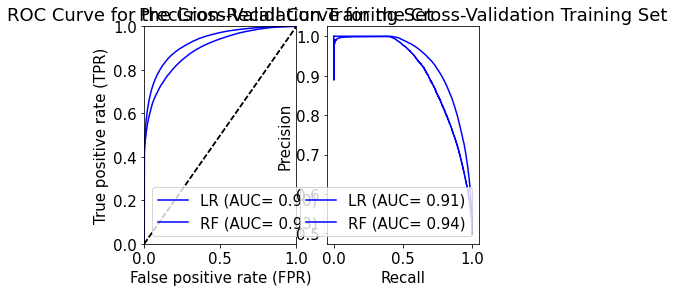

In [31]:
# Plot ROC and PR curves for Logistic Regression
model.plot_roc_prc_cv(gsearch_log.best_estimator_, X_train_scaled, y_train,
                       color= 'b', label = 'LR (AUC= %0.2f)')

# Plot ROC and PR curves for Random Forest
model.plot_roc_prc_cv(rsearch_rf.best_estimator_, X_train_scaled, y_train,
                       color= 'b', label = 'RF (AUC= %0.2f)')

# C. Prediction on the Test Set 

## C-1. Logistic Regression

In [32]:
log_reg_best = gsearch_log.best_estimator_
model.test_prediction(log_reg_best, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.808038
AUROC: 0.896863
AUPRC: 0.911888
Predicted classes: [0 1]
Confusion matrix:
 [[10785  1536]
 [ 3183  9079]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82     12321
           1       0.86      0.74      0.79     12262

    accuracy                           0.81     24583
   macro avg       0.81      0.81      0.81     24583
weighted avg       0.81      0.81      0.81     24583

---------------------------------------------------------------------------


## C-2. Random Forest

In [33]:
rf_best = rsearch_rf.best_estimator_
model.test_prediction(rf_best, X_train_scaled, y_train, X_test_scaled, y_test)

---------------------------------------------------------------------------
Test accuracy:  0.855144
AUROC: 0.933678
AUPRC: 0.941984
Predicted classes: [0 1]
Confusion matrix:
 [[10940  1381]
 [ 2180 10082]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86     12321
           1       0.88      0.82      0.85     12262

    accuracy                           0.86     24583
   macro avg       0.86      0.86      0.85     24583
weighted avg       0.86      0.86      0.85     24583

---------------------------------------------------------------------------


## C-3. ROC and PR Curves on the Test Set

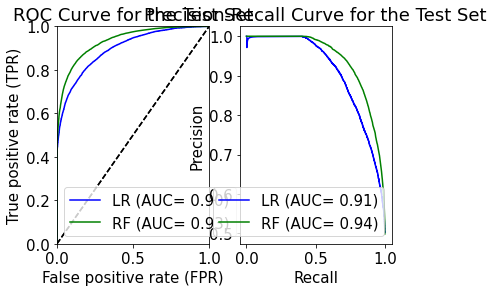

In [34]:
# Plot ROC and PR curves for Logistic Regression
model.plot_roc_prc(log_reg_best, X_train_scaled, y_train, X_test_scaled, y_test,
                       color= 'b', label = 'LR (AUC= %0.2f)')

# Plot ROC and PR curves for Random Forest
model.plot_roc_prc(rf_best, X_train_scaled, y_train, X_test_scaled, y_test,
                       color= 'g', label = 'RF (AUC= %0.2f)')